# Gaussian Process inference in PyMC3
This is the first step in modelling Species occurrence. 
The good news is that MCMC works,
The bad one is that it's computationally intense.


In [4]:
# Load Biospytial modules and etc.
%matplotlib inline
import sys
sys.path.append('/apps/external_plugins/spystats/')
import django
django.setup()
import pandas as pd
import matplotlib.pyplot as plt
## Use the ggplot style
plt.style.use('ggplot')
import numpy as np

In [5]:
from spystats import tools

## Simulated data


In [27]:
latent_field = tools.MaternVariogram(sill=1,range_a=0.13,kappa=3.0/2.0)

In [28]:
## Simulations with non squared grid
grid = tools.createGrid(grid_sizex=50,minx=-1,maxx=2,miny=-1,maxy=2,grid_sizey=70)

In [29]:
X,Y,Z = tools.simulatedGaussianFieldAsPcolorMesh(latent_field,grid_sizex=50,minx=0,maxx=1,miny=0,maxy=1,
                                                 grid_sizey=50)

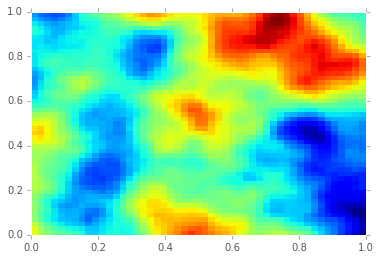

In [30]:
plt.pcolormesh(X,Y,Z)

In [46]:
import pandas as pd
data = pd.DataFrame({'X':X.ravel(),'Y':Y.ravel(),'Z':Z.ravel()})

In [33]:
## Model Specification
import pymc3 as pm


/opt/conda/envs/biospytial/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [44]:
X,Y,Z = tools.simulatedGaussianFieldAsPcolorMesh(latent_field,grid_sizex=50,minx=0,maxx=1,miny=0,maxy=1,
                                                 grid_sizey=50)

In [43]:
sill=1
range_a=0.13
kappa=3.0/2.0
ls = 0.2
tau = 2.0
cov = pm.gp.cov.Matern32(2, range_a,active_dims=[0,1])


In [50]:
K = cov(data[['X','Y']].values).eval()

In [64]:
plt.figure(figsize=(14,4))
dist = pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=1)

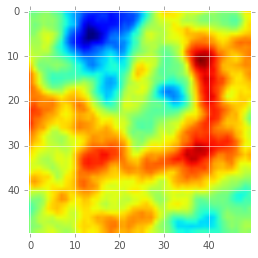

In [66]:
plt.imshow(dist.reshape(50,50))

In [63]:
## Ok, let's try to make some inference

array([-0.07352187, -0.30978285])

In [76]:
import theano.tensor as tt

In [140]:

np.random.seed(1)

# Number of training points
n = 30

##Vector column, [:,None] effect
X0 = np.sort(3 * np.random.rand(n))[:, None]

# Number of points at which to interpolate
## Creating the domain
m = 100
X = np.linspace(0, 3, m)[:, None]

# Covariance kernel parameters
## \tau nugget 
noise = 0.1
## \phi = ?
lengthscale = 0.3
## \sigma^{2} ?
f_scale = 1

## Covariance function
## Cov = \sigma^{2} * \rho(\phi) (No nugget)
cov = f_scale * pm.gp.cov.ExpQuad(1, lengthscale)

## Evaluate Covariance at X0 (observations / simulations)
K = cov(X0)

## THis calculates the covariance structure between the vectors X0 and X
## That is calculates distance matrix of X0 and X .  If cov is only one value (X) then is equivalent to cov(X,X)
K_s = cov(X0, X)

##, Compose the Covariance with nugget effect of noise = \ tau^{2}
## So this includes kernel
K_noise = K + noise * tt.eye(n)

# Add very slight perturbation to the covariance matrix diagonal to improve numerical stability
##  Regularisation
K_stable = K + 1e-12 * tt.eye(n)

# Observed data / Simulate data
f = np.random.multivariate_normal(mean=np.zeros(n), cov=K_noise.eval())



In [154]:
## Plot this
K_x0x0 = cov(X0, X0)
K_x0 = cov(X0)

In [161]:
np.array_equal(K_x0x0.eval(), K_x0.eval())


True

In [151]:
cov(X,X).eval().shape

(100, 100)

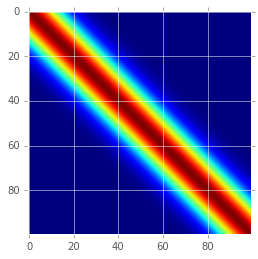

In [147]:
plt.imshow(cov(X,X).eval())

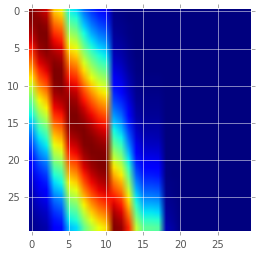

In [143]:
plt.imshow(K_s.eval()[:30,:30].T)

In [162]:
type(K_s)

theano.tensor.var.TensorVariable

## Examine actual posterior distribution

The posterior is analytically tractable so we can compute the posterior mean explicitly. Rather than computing the inverse of the covariance matrix K, we use the numerically stable calculation described Algorithm 2.1 in the book “Gaussian Processes for Machine Learning” (2006) by Rasmussen and Williams, which is available online for free.

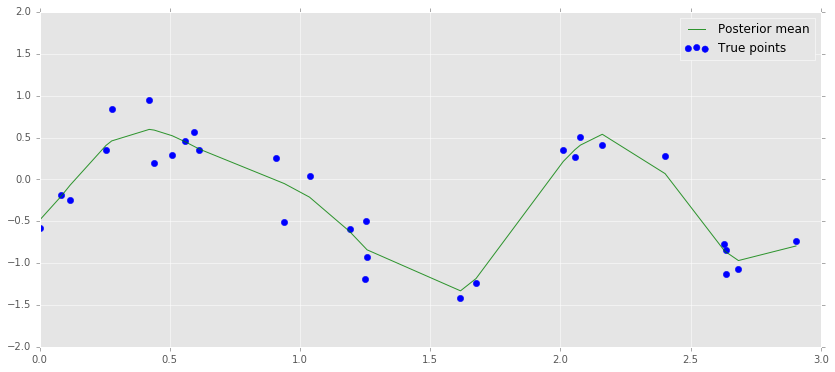

In [165]:
fig, ax = plt.subplots(figsize=(14, 6));
ax.scatter(X0, f, s=40, color='b', label='True points');

# Analytically compute posterior mean
## This is the cholesky decomposition of the Covariance Matrix with kernel nugget
L = np.linalg.cholesky(K_noise.eval())
## Faith step, This solves the base x's such that Lx = f and the uses x for solving y's such that L.T y = x
alpha = np.linalg.solve(L.T, np.linalg.solve(L, f))
## Multiply the posterior (ALgorithm 2.1 in Rasmunssen)
## Using the "extended matrix" K_s
post_mean = np.dot(K_s.T.eval(), alpha)

ax.plot(X0, post_mean, color='g', alpha=0.8, label='Posterior mean');

ax.set_xlim(0, 3);
ax.set_ylim(-2, 2);
ax.legend();

Ok, it's good to have the analitical solution but not always possible sooooo.
Let's do some computing.
## Model in PyM3

In [166]:
with pm.Model() as model:
    # The actual distribution of f_sample doesn't matter as long as the shape is right since it's only used
    # as a dummy variable for slice sampling with the given prior
    ### From doc:
    ### 
    
    f_sample = pm.Flat('f_sample', shape=(n, ))

    ## Actually, pm.Flat is a zero array of shape n
    # Likelihood
    ## The covariance is only in the diagonal
    
    y = pm.MvNormal('y', observed=f, mu=f_sample, cov=noise * tt.eye(n), shape=n)

    # Interpolate function values using noisy covariance matrix
    ## Deterministic allows to compose (do algebra) with RV in many different ways. 
    ##While these transformations work seamlessly, its results are not stored automatically. 
    ##Thus, if you want to keep track of a transformed variable, you have to use pm.Determinstic:
    ## from http://docs.pymc.io/notebooks/api_quickstart.html
    
    ## So in this case is transforming the rv into:
    ## the low triangular cholesky decomposition of the Covariance with nugget
    L = tt.slinalg.cholesky(K_noise)
    ## So this is for calculating the "kernel" part of the MVN i.e. (mu -x).T * (LL.T)^-1 * (mu-x)
    ## but considering mu = 0 we have that x = linalg.solve(L,y) (because Lx = y)
    ## Then, L.T*x)
    f_pred = pm.Deterministic('f_pred', tt.dot(K_s.T, tt.slinalg.solve(L.T, tt.slinalg.solve(L, f_sample))))

    # Use elliptical slice sampling
    ess_step = pm.EllipticalSlice(vars=[f_sample], prior_cov=K_stable)
    trace = pm.sample(5000, start=model.test_point, step=[ess_step], progressbar=False, random_seed=1)

ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


## Evaluate posterior fit

The posterior samples are consistent with the analytically derived posterior and behaves how one would expect–narrower near areas with lots of observations and wider in areas with more uncertainty.

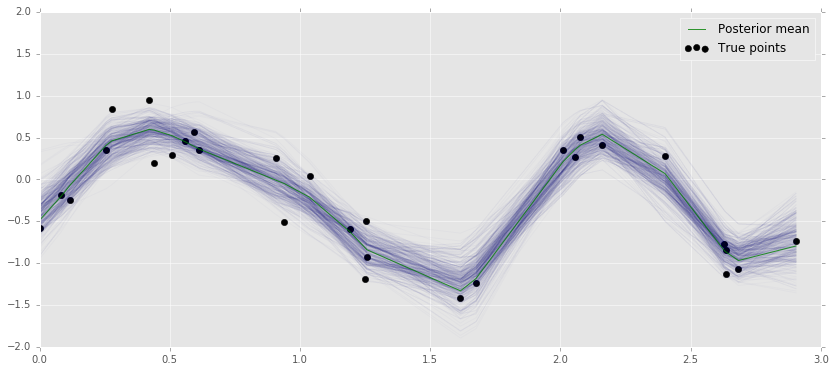

In [169]:
fig, ax = plt.subplots(figsize=(14, 6));
for idx in np.random.randint(4000, 5000, 500):
    ax.plot(X0, trace['f_pred'][idx],  alpha=0.02, color='navy')
ax.scatter(X0, f, s=40, color='k', label='True points');
ax.plot(X0, post_mean, color='g', alpha=0.8, label='Posterior mean');
ax.legend();
ax.set_xlim(0, 3);
ax.set_ylim(-2, 2);

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fabd735e750>,
      dtype=object)

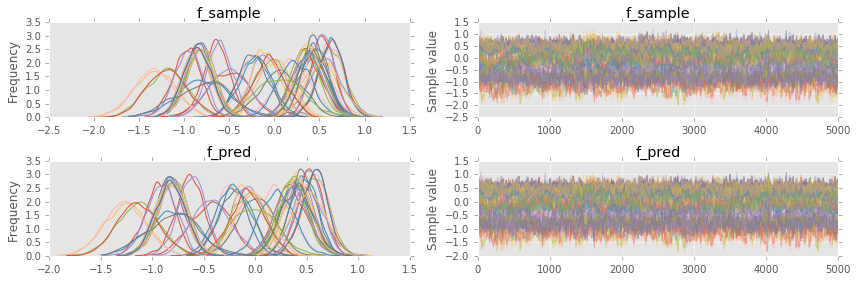

In [170]:
pm.traceplot(trace)

# Clasification
In Gaussian process classification, the likelihood is not normal and thus the posterior is not analytically tractable. The prior is again a multivariate normal with covariance matrix K, and the likelihood is the standard likelihood for logistic regression:
\begin{equation}
L(y | f) = \Pi_n \sigma(y_n, f_n)
\end{equation}

## Generate some example data

We generate random samples from a Gaussian process, assign any points greater than zero to a “positive” class, and assign all other points to a “negative” class.

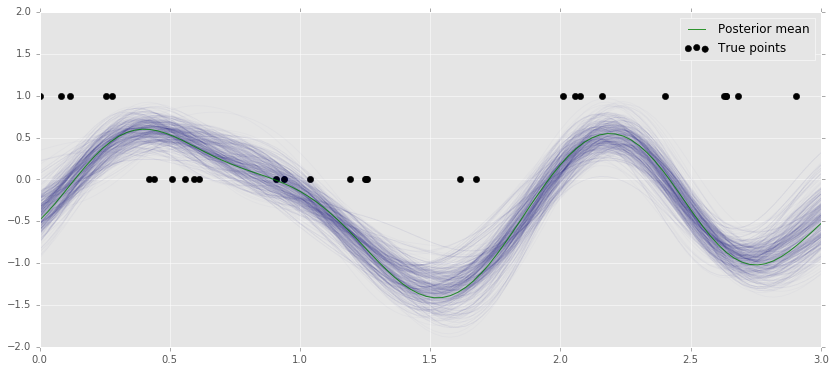

In [82]:
np.random.seed(5)
f = np.random.multivariate_normal(mean=np.zeros(n), cov=K_stable.eval())

# Separate data into positive and negative classes
f[f > 0] = 1
f[f <= 0] = 0

fig, ax = plt.subplots(figsize=(14, 6));
for idx in np.random.randint(4000, 5000, 500):
    ax.plot(X, trace['f_pred'][idx],  alpha=0.02, color='navy')
ax.scatter(X0, f, s=40, color='k', label='True points');
ax.plot(X, post_mean, color='g', alpha=0.8, label='Posterior mean');
ax.legend();
ax.set_xlim(0, 3);
ax.set_ylim(-2, 2);



## Sample from posterior distribution

In [84]:
with pm.Model() as model:
    # Again, f_sample is just a dummy variable
    f_sample = pm.Flat('f_sample', shape=n)
    f_transform = pm.invlogit(f_sample)

    # Binomial likelihood
    y = pm.Binomial('y', observed=f, n=np.ones(n), p=f_transform, shape=n)

    # Interpolate function values using noiseless covariance matrix
    L = tt.slinalg.cholesky(K_stable)
    f_pred = pm.Deterministic('f_pred', tt.dot(K_s.T, tt.slinalg.solve(L.T, tt.slinalg.solve(L, f_transform))))

    # Use elliptical slice sampling
    ess_step = pm.EllipticalSlice(vars=[f_sample], prior_cov=K_stable)
    trace = pm.sample(5000, start=model.test_point, step=[ess_step], progressbar=False, random_seed=1)

## Evaluate posterior fit

The posterior looks good, though the fit is, unsurprisingly, erratic outside the range of the observed data.

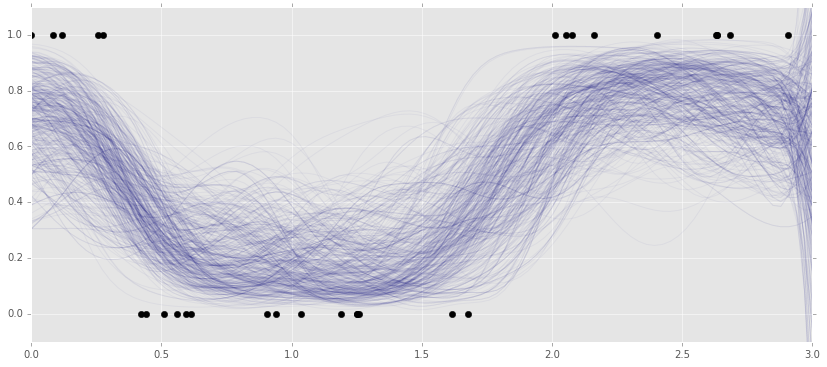

In [85]:
fig, ax = plt.subplots(figsize=(14, 6));
for idx in np.random.randint(4000, 5000, 500):
    ax.plot(X, trace['f_pred'][idx],  alpha=0.04, color='navy')
ax.scatter(X0, f, s=40, color='k');
ax.set_xlim(0, 3);
ax.set_ylim(-0.1, 1.1);